### Data Analysis

In [81]:
import requests
import pandas as pd

url = "https://file.notion.so/f/f/f3d54618-4ee1-480d-b8f7-25c361e2c7b2/12d14740-f5b4-4ce9-9d4d-b9d0b3cd5548/data.parquet?table=block&id=6fa5d867-4063-4844-aebb-4be60a25af39&spaceId=f3d54618-4ee1-480d-b8f7-25c361e2c7b2&expirationTimestamp=1764439200000&signature=F1V99Bt_JEetnb8bh4dCF97fEUbtYgbtS41XpSgCCmk&downloadName=data.parquet"
r = requests.get(url)
with open("data.parquet", "wb") as f:
    f.write(r.content)

df = pd.read_parquet("data.parquet")
print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [82]:
df.isna()
df.isna().sum()

banknifty    1500
nifty        2000
tte             0
dtype: int64

In [83]:
####### I have to find, how many times Consecutive missing blocks are there

### 1.I can remove this row completely
### 2.Using KNN or mean(upper + lower)/2 to fill the missing value(if not consecutive)
### 3.ffill() or bfill() for consecutive missing values(I can)

# df = df.dropna(how='any')
# df.isna().sum()

df = df.ffill()
df.isna().sum()

banknifty    0
nifty        0
tte          0
dtype: int64

### Base Model

In [84]:
### using spread in IV between nifty and banknifty,
### 1.banknifty_iv becomes too high relative to nifty_iv -->sell banknifty
### 2.banknifty_iv becomes too low relative to nifty_iv  -->buy banknifty
### this position directly depends on, how close are to expiry(TTE^0.7)

# When z-score crosses an upper threshold, go SHORT:
# Sell stock A
# Buy stock B
# When the z-score crosses the lower threshold, go LONG:
# Buy stock A
# Sell stock B


In [ ]:
import numpy as np
import pandas as pd

############ This calulates spread and zscore ##########
class SpreadCalculator:
    def __init__(self, window=20):
        self.window = window

    def compute_spread(self, df):
        df['spread'] = df['banknifty'] - df['nifty']
        return df

    def compute_zscore(self, df):
        df['spread_mean'] = df['spread'].rolling(self.window).mean()
        df['spread_std']  = df['spread'].rolling(self.window).std()
        df['zscore']      = (df['spread'] - df['spread_mean']) / df['spread_std']
        df['zscore']      = df['zscore'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df


############# This class stores the trade data ##############
class PairTrade:
    def __init__(self, entry_time, entry_z, entry_spread, entry_mean, tte):
        self.entry_time     = entry_time
        self.entry_z        = entry_z               # ENTRY z-score
        self.entry_spread   = entry_spread
        self.entry_mean     = entry_mean            # ENTRY mean spread
        self.tte            = tte
        self.direction      = "LONG" if entry_z < 0 else "SHORT"

        self.exit_time      = None
        self.exit_spread    = None
        self.exit_z         = None                  # EXIT z-score
        self.exit_mean      = None                  # EXIT mean spread
        self.pnl            = None

    def close(self, exit_time, exit_spread, exit_z, exit_mean):
        self.exit_time   = exit_time
        self.exit_spread = exit_spread
        self.exit_z      = exit_z
        self.exit_mean   = exit_mean

        if self.direction == "LONG":
            self.pnl = (self.entry_spread - exit_spread) * (self.tte ** 0.7)
        else:
            self.pnl = (exit_spread - self.entry_spread) * (self.tte ** 0.7)

        return self.pnl


############# Pair Trading Main Class #############
class PairTradingStrategy:
    def __init__(self, upper=2.0, lower=-2.0, exit_threshold=0.25, window=30):
        self.upper          = upper
        self.lower          = lower
        self.exit_threshold = exit_threshold

        self.spread_model   = SpreadCalculator(window)
        self.open_trade     = None
        self.ledger         = []

    def process(self, df):

        df = self.spread_model.compute_spread(df)
        df = self.spread_model.compute_zscore(df)

        for idx, row in df.iterrows():
            current_time = idx  
            z            = row['zscore']
            spread       = row['spread']
            mean_val     = row['spread_mean']
            tte          = row['tte']

            ########### ENTRY CONDITIONS ###########
            if self.open_trade is None:
                if z > self.upper or z < self.lower:
                    self.open_trade = PairTrade(
                        entry_time   = current_time,
                        entry_z      = z,
                        entry_spread = spread,
                        entry_mean   = mean_val,
                        tte          = tte
                    )

            ########### EXIT CONDITIONS ###########
            else:
                if abs(z) < self.exit_threshold:
                    pnl = self.open_trade.close(
                        exit_time   = current_time,
                        exit_spread = spread,
                        exit_z      = z,
                        exit_mean   = mean_val
                    )

                    self.ledger.append({
                        "entry_time": self.open_trade.entry_time,
                        "exit_time": current_time,
                        "direction": self.open_trade.direction,

                        #### Spread values
                        "entry_spread": self.open_trade.entry_spread,
                        "exit_spread": spread,

                        #### Z-scores
                        "entry_zscore": self.open_trade.entry_z,
                        "exit_zscore": z,

                        ##### Mean spread values
                        "entry_mean_zscore": self.open_trade.entry_mean,
                        "exit_mean_zscore": mean_val,

                        #### P/L
                        "pnl": pnl
                    })

                    self.open_trade = None

        return pd.DataFrame(self.ledger)


In [88]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection

def plot_pair_trades_fast(df, trades_df):
    plt.figure(figsize=(16, 8))

    # Convert index to matplotlib number format
    df_time = mdates.date2num(df.index.to_pydatetime())

    # Z-score plot
    plt.plot(df_time, df['zscore'], label='Z-score', linewidth=1)

    # Threshold lines
    plt.axhline(2, color='gray', linestyle='--', linewidth=0.8)
    plt.axhline(-2, color='gray', linestyle='--', linewidth=0.8)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.7)

    # -------- ENTRY / EXIT (convert to numeric first) ----------
    entry_x = mdates.date2num(trades_df['entry_time'].dt.to_pydatetime())
    exit_x  = mdates.date2num(trades_df['exit_time'].dt.to_pydatetime())

    plt.scatter(entry_x, trades_df['entry_zscore'], color='green', s=40, label='Entry')
    plt.scatter(exit_x,  trades_df['exit_zscore'],  color='red', s=40, label='Exit')

    # ----------- Fast Trade Connection Lines ---------------
    segments = [
        [(entry_x[i], trades_df['entry_zscore'].iloc[i]),
         (exit_x[i],  trades_df['exit_zscore'].iloc[i])]
        for i in range(len(trades_df))
    ]

    lc = LineCollection(segments, colors="orange", linewidths=1.0, alpha=0.5)
    plt.gca().add_collection(lc)

    # Format X-axis for time
    plt.gca().xaxis_date()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    plt.title("Z-Score Pair Trading (Fast Plot)")
    plt.xlabel("Time")
    plt.ylabel("Z-Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


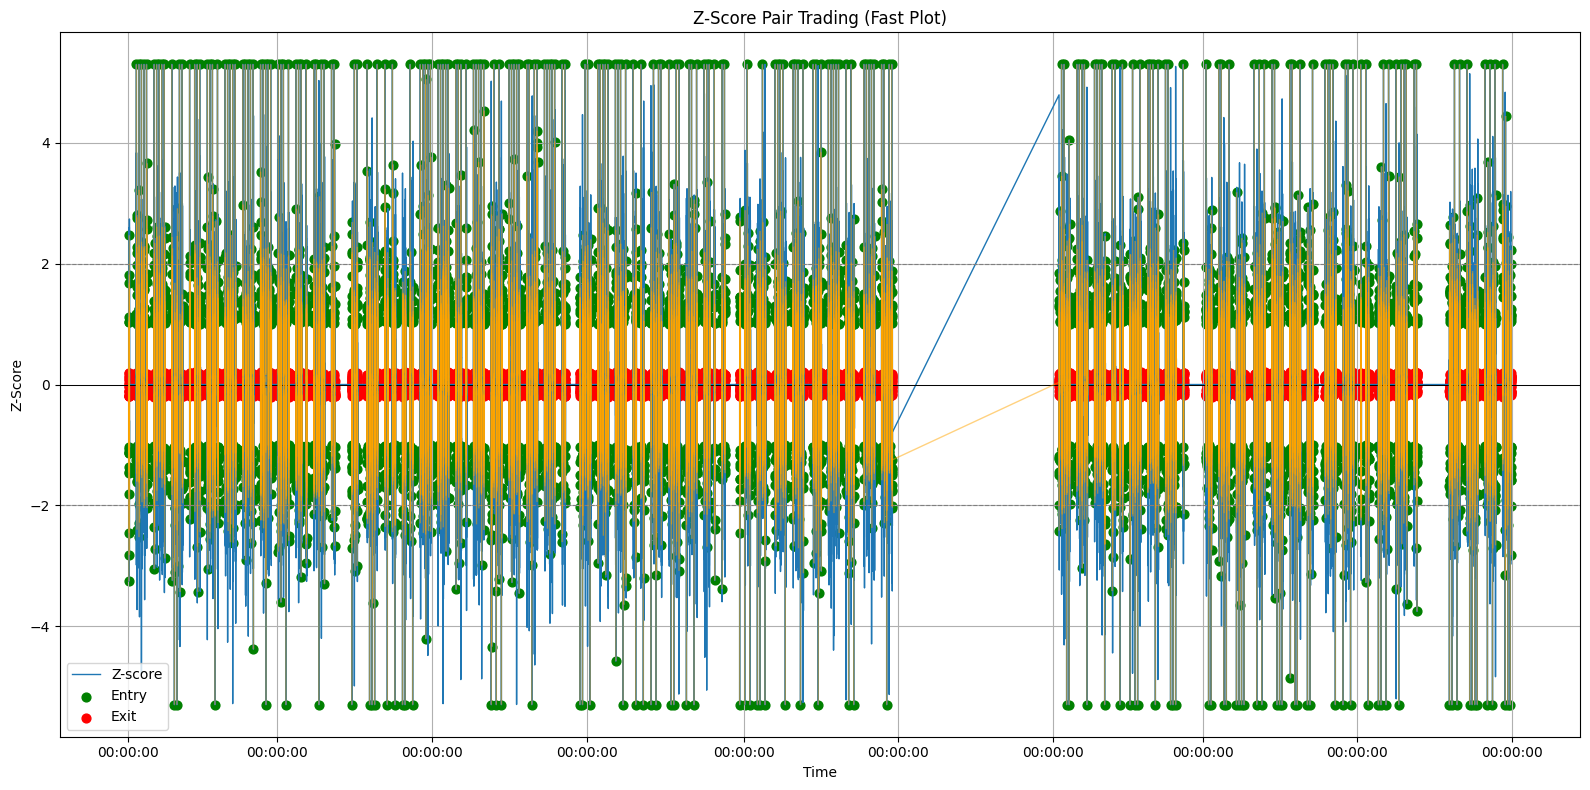

              entry_time           exit_time direction  entry_spread  \
0    2021-01-01 09:44:00 2021-01-01 10:01:00      LONG      0.078458   
1    2021-01-01 10:08:00 2021-01-01 10:25:00      LONG      0.075791   
2    2021-01-01 10:27:00 2021-01-01 10:31:00     SHORT      0.079335   
3    2021-01-01 10:47:00 2021-01-01 10:56:00     SHORT      0.079419   
4    2021-01-01 11:05:00 2021-01-01 11:07:00      LONG      0.076299   
...                  ...                 ...       ...           ...   
6965 2022-06-30 14:20:00 2022-06-30 14:22:00      LONG      0.023421   
6966 2022-06-30 14:23:00 2022-06-30 14:27:00     SHORT      0.025912   
6967 2022-06-30 14:32:00 2022-06-30 14:46:00     SHORT      0.026076   
6968 2022-06-30 14:51:00 2022-06-30 15:08:00     SHORT      0.027703   
6969 2022-06-30 15:15:00 2022-06-30 15:30:00      LONG      0.024572   

      exit_spread  entry_zscore  exit_zscore  entry_mean_zscore  \
0        0.079032     -1.439055     0.116826           0.082597   
1

In [90]:
strategy = PairTradingStrategy(upper=1, lower=-1, exit_threshold=0.2, window=30)

ledger = strategy.process(df)
plot_pair_trades_fast(df, ledger)
print(ledger)



In [91]:
class StrategyMetrics:    
    def __init__(self, ledger_df):
        self.ledger = ledger_df.copy()
        if self.ledger.empty:
            raise ValueError("Ledger is empty - no trades executed.")

        self.returns = self.ledger["pnl"]

    def total_pnl(self):
        return self.returns.sum()

    def sharpe_ratio(self):
        if self.returns.std() == 0:
            return 0
        return (self.returns.mean() / self.returns.std()) * np.sqrt(252)

    def max_drawdown(self):
        cum = self.returns.cumsum()
        roll_max = cum.cummax()
        drawdown = roll_max - cum
        return drawdown.max()

    def win_rate(self):
        wins = (self.returns > 0).sum()
        total = len(self.returns)
        return wins / total

    def avg_win(self):
        wins = self.returns[self.returns > 0]
        return wins.mean() if len(wins) > 0 else 0

    def avg_loss(self):
        losses = self.returns[self.returns < 0]
        return losses.mean() if len(losses) > 0 else 0

    def profit_factor(self):
        total_win = self.returns[self.returns > 0].sum()
        total_loss = abs(self.returns[self.returns < 0].sum())
        return total_win / total_loss if total_loss != 0 else np.inf

    def expectancy(self):
        return self.returns.mean()  #avg. p/l per trade

    def summary(self):
        return {
            "Total PnL": self.total_pnl(),
            "Sharpe Ratio": self.sharpe_ratio(),
            "Max Drawdown": self.max_drawdown(),
            "Win Rate": self.win_rate(),
            "Avg Win": self.avg_win(),
            "Avg Loss": self.avg_loss(),
            "Profit Factor": self.profit_factor(),
            "Expectancy": self.expectancy(),
            "Number of Trades": len(self.returns)
        }

In [92]:
# strategy = PairTradingStrategy()
ledger = strategy.process(df)

In [93]:
metrics = StrategyMetrics(ledger)
print(metrics.summary())

{'Total PnL': -278.437328715387, 'Sharpe Ratio': -5.8779906778041155, 'Max Drawdown': 278.43156784562495, 'Win Rate': 0.11692969870875179, 'Avg Win': 0.014856818249803767, 'Avg Loss': -0.02467824057913953, 'Profit Factor': 0.08001420219455856, 'Expectancy': -0.01997398340856435, 'Number of Trades': 13940}
